In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

In [2]:
RESULTS_DIR = os.path.join(BASE_PATH, 'results')

In [3]:
from lib import fca_interp as fcai

In [4]:
from lib.utils_ import powerset

In [5]:
from importlib import reload

In [6]:
from sklearn.datasets import load_boston

In [7]:
from copy import copy, deepcopy

# Load Data

In [8]:
from keras.datasets import mnist

Using TensorFlow backend.


In [9]:
img_rows, img_cols = 28, 28

In [10]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 15s 1us/step


In [11]:
x_test = x_test.astype('float32')
x_test /= 255

In [12]:
x_test_flat = x_test.reshape(-1, img_rows*img_cols)
x_test_flat.shape

(10000, 784)

## CatBoost

In [13]:
from catboost import CatBoostClassifier, Pool

In [14]:
cb = CatBoostClassifier()

In [15]:
cb.load_model('cb_mnist_2020.06.06.model')

In [16]:
cb.predict(x_test_flat).flatten()

array([7, 2, 1, ..., 4, 5, 6])

## SVC

In [17]:
import pickle

In [18]:
with open('svc_mnist_2020.06.06.pickle', 'rb') as f:
    svc = pickle.load(f)

In [19]:
svc.predict(x_test_flat[:10])

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9], dtype=uint8)

## NN

In [20]:
from tensorflow import keras

In [21]:
model = keras.models.load_model('nn_mnist_2020.06.06.pickle')

In [22]:
x_test_nn = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

In [23]:
model.predict_classes(x_test_nn)

array([7, 2, 1, ..., 4, 5, 6])

In [24]:
preds_ds = pd.read_csv(DATASETS_DIR+'/mnist_ds_preds_2020.06.06.csv', index_col=0)
preds_ds.index = preds_ds.index.astype(str)

In [25]:
preds_ds['y'] = y_test

In [26]:
preds_ds

,preds_cb,preds_svc,preds_nn,y
0,7,7,7,7
1,2,2,2,2
2,1,1,1,1
3,0,0,0,0
4,4,4,4,4
...,...,...,...,...
9995,2,2,2,2
9996,3,3,3,3
9997,4,4,4,4
9998,5,5,5,5


# Compare BB with FCA

In [28]:
ds = pd.DataFrame(x_test_flat)
#ds = ds.astype(int)
print(ds.shape)
ds.columns = [f"({y},{x})" for y in range(img_rows) for x in range(img_cols)]
ds.index = ds.index.astype(str)
ds.head()

(10000, 784)


,"(0,0)","(0,1)","(0,2)","(0,3)","(0,4)","(0,5)","(0,6)","(0,7)","(0,8)","(0,9)",...,"(27,18)","(27,19)","(27,20)","(27,21)","(27,22)","(27,23)","(27,24)","(27,25)","(27,26)","(27,27)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
ds = ds.head(1000)

In [30]:
from lib import pattern_structure

In [104]:
pattern_structure = reload(pattern_structure)
fcai = reload(fcai)

In [105]:
mvcntx = fcai.MultiValuedContext(ds, cat_attrs=[], y_true=preds_ds.loc[ds.index, 'y'])
fm = fcai.FormalManager(mvcntx)

In [41]:
def intent_to_picture(int_, columns):
    return np.array([np.mean(int_.get(x,0)) for x in columns]).reshape(img_rows, img_cols)

# Сравнение

## Внутри каждой конкретной кросс валидации

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

Модели для сравнения:
* Logistic regression
* Decision Tree small
* Decision Tree full
* GAM (?)
* 

Что сравниваем:
* Feature Importance
* Качество предсказаний на обучающей выборке
* Качество предсказаний на тестовой выборке
* Качество предсказаний предсказаний модели на обучающей выборке
* Качество предсказаний предсказаний модели на тестовой выборке

Сравнение проводим для каждого чёрного ящика:
* CatBoost
* SVC
* Neural Network

In [44]:
bb_types = ['cb','nn','svc']

In [45]:
from sklearn.metrics import f1_score

In [46]:
def get_fimps_cb(ds_train, cb):
    sv = cb.get_feature_importance(Pool(ds_train[cat_feats+real_feats], preds_ds.loc[ds_train.index, 'preds_cb'],  cat_features=cat_feats), 'ShapValues')
    sv_ds = pd.DataFrame(sv, columns=cat_feats+real_feats+['bias']).drop('bias',1)
    fimps_sv = sv_ds.abs().median().sort_values(ascending=False)
    return fimps_sv

In [47]:
def get_fimps_nn(ds_train, model):
    explainer = shap.DeepExplainer(model, ds_train.values)
    sv = explainer.shap_values(ds_train.values)[0]
    sv_ds = pd.DataFrame(sv, columns=ds_train.columns)
    
    fimps_sv = sv_ds.abs().median().reset_index()
    fimps_sv.columns = ['feature_ohe','sv']
    fimps_sv['feature'] = [x.split('__')[0] if '__' in x else x for x in fimps_sv['feature_ohe']]
    fimps_sv['sv_abs'] = fimps_sv['sv'].abs()
    fimps_sv = fimps_sv.groupby('feature')['sv_abs'].sum()
    #fimps_sv.sort_values(ascending=False)
    return fimps_sv

In [48]:
def get_fimps_svc(ds_train, svc, k=10, nsamples=10):
    svds = shap.kmeans(ds_train, k)
    explainer =shap.KernelExplainer(svc.predict, svds)
    sv = explainer.shap_values(ds_train.values, nsamples=nsamples)
    
    sv_ds = pd.DataFrame(sv, columns=ds_train.columns)

    fimps_sv = sv_ds.abs().median().reset_index()
    fimps_sv.columns = ['feature_ohe','sv']
    fimps_sv['feature'] = [x.split('__')[0] if '__' in x else x for x in fimps_sv['feature_ohe']]
    fimps_sv['sv_abs'] = fimps_sv['sv'].abs()
    fimps_sv = fimps_sv.groupby('feature')['sv_abs'].sum()
    return fimps_sv

In [49]:
def get_fimps_lr(ds_train, lr):
    fimps_lr = pd.Series(lr.coef_[0], index=ds_train.columns).reset_index()
    fimps_lr.columns = ['feature_ohe','sv']
    fimps_lr['feature'] = [x.split('__')[0] if '__' in x else x for x in fimps_lr['feature_ohe']]
    fimps_lr['sv_abs'] = fimps_lr['sv'].abs()
    fimps_lr = fimps_lr.groupby('feature')['sv_abs'].sum()
    return fimps_lr

In [106]:
def test_lr(ds, preds_ds, train_idxs_cv, test_idxs_cv, bb_types):
    stat = {}
    
    lr = LogisticRegression()
    lr.fit(ds.loc[train_idxs_cv], preds_ds.loc[train_idxs_cv, 'y'])
    preds_test_real = lr.predict(ds.loc[test_idxs_cv])
    stat[f"acc_test_real_lr"] = accuracy_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    #stat[f"f1_test_real_lr"] = f1_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)

    for bb_type in bb_types:
        lr = LogisticRegression()
        lr.fit(ds.loc[train_idxs_cv], preds_ds.loc[train_idxs_cv, f'preds_{bb_type}'])
        preds_train_bb = lr.predict(ds.loc[train_idxs_cv])
        preds_test_bb = lr.predict(ds.loc[test_idxs_cv])

        stat[f"{bb_type}_acc_train_bb_lr"] = accuracy_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_acc_test_bb_lr"] = accuracy_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        #stat[f"{bb_type}_f1_train_bb_lr"] = f1_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        #stat[f"{bb_type}_f1_test_bb_lr"] = f1_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        #stat[f"{bb_type}_lr_fimps"] =  get_fimps_lr(ds, lr)
    
    return stat

In [107]:
def test_dts(ds, preds_ds, train_idxs_cv, test_idxs_cv, bb_types):
    dt_small = DecisionTreeClassifier(max_depth=5)
    dt_small.fit(ds.loc[train_idxs_cv], preds_ds.loc[train_idxs_cv,'y'])
    preds_test_real = dt_small.predict(ds.loc[test_idxs_cv])
    stat = {}
    stat[f"acc_test_real_dts"] = accuracy_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    #stat[f"f1_test_real_dts"] = f1_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)

    for bb_type in bb_types:
        dt_small = DecisionTreeClassifier(max_depth=5)
        dt_small.fit(ds.loc[train_idxs_cv], preds_ds.loc[train_idxs_cv, f"preds_{bb_type}"])
        preds_train_bb = dt_small.predict(ds.loc[train_idxs_cv])
        preds_test_bb = dt_small.predict(ds.loc[test_idxs_cv])

        fimps_dts = pd.Series(dt_small.feature_importances_, index=ds.columns)

        stat[f"{bb_type}_acc_train_bb_dts"] = accuracy_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_acc_test_bb_dts"] = accuracy_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        
        #stat[f"{bb_type}_f1_train_bb_dts"] = f1_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        #stat[f"{bb_type}_f1_test_bb_dts"] = f1_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        #stat[f"{bb_type}_dts_fimps"] = fimps_dts
    return stat

In [108]:
def test_dtl(ds, preds_ds, train_idxs_cv, test_idxs_cv, bb_types):
    dt_small = DecisionTreeClassifier()
    dt_small.fit(ds.loc[train_idxs_cv], preds_ds.loc[train_idxs_cv,'y'])
    preds_test_real = dt_small.predict(ds.loc[test_idxs_cv])
    stat = {}
    stat[f"acc_test_real_dtl"] = accuracy_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    #stat[f"f1_test_real_dtl"] = f1_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)

    for bb_type in bb_types:
        dt_small = DecisionTreeClassifier()
        dt_small.fit(ds.loc[train_idxs_cv], preds_ds.loc[train_idxs_cv, f"preds_{bb_type}"])
        preds_train_bb = dt_small.predict(ds.loc[train_idxs_cv])
        preds_test_bb = dt_small.predict(ds.loc[test_idxs_cv])

        fimps_dts = pd.Series(dt_small.feature_importances_, index=ds.columns)

        stat[f"{bb_type}_acc_train_bb_dtl"] = accuracy_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_acc_test_bb_dtl"] = accuracy_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        
        #stat[f"{bb_type}_f1_train_bb_dtl"] = f1_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        #stat[f"{bb_type}_f1_test_bb_dtl"] = f1_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        #stat[f"{bb_type}_dtl_fimps"] = fimps_dts
    return stat

In [109]:
from sklearn.ensemble import RandomForestClassifier

In [110]:
def test_fca_full(mvcntx, train_idxs_cv, test_idxs_cv, concepts, preds_ds, bb_types, verb=False):
    mvcntx_red = copy(mvcntx)
    if len(train_idxs_cv)+len(test_idxs_cv)<len(mvcntx_red.get_objs()):
        to_del = [g for g in mvcntx.get_objs() if not g in train_idxs_cv and not g in test_idxs_cv]
        mvcntx_red.drop_objects_from_context(to_del)
        
    mvcntx_train = copy(mvcntx_red)
    mvcntx_train.drop_objects_from_context(test_idxs_cv)
    
    mvcntx_test = copy(mvcntx_red)
    mvcntx_test.drop_objects_from_context(train_idxs_cv)
    
    if verb:
        print(f'modified contexts')#: train_size={len(mvcntx_train.get_objs())}, test_size={len(mvcntx_test.get_objs())}')
    fm_cv = fcai.FormalManager(mvcntx_train)
    #fm_cv.set_concepts(concepts)
    fm_cv._context._y_true = preds_ds.loc[train_idxs_cv, 'y'].values
    print(len(fm_cv._context.get_objs()), fm_cv._context._data.shape, len(train_idxs_cv))
    fm_cv.construct_concepts(algo='RandomForest', rf_params=RF_PARAMS, rf_class=RandomForestClassifier)
    
    fm_cv.construct_lattice()
    if verb:
        print(f'construct lattice, n concepts: {len(fm_cv.get_concepts())}')
    for c in fm_cv.get_concepts():
        ext_ = c.get_extent()
        c._metrics['mean_y_true'] = preds_ds.loc[ext_, 'y'].value_counts().sort_values(ascending=False).index[0] #.mode()
        for i in range(10):
            c._metrics[f'mean_y_true_{i}'] = (preds_ds.loc[ext_, 'y'].astype(int)==int(i)).mean()
        
    if verb:
        print('recalc metrics')
            
    metrics = [f'mean_y_true_{i}' for i in range(10)]
    preds_test_real = fm_cv.predict_context(mvcntx_test, metric=metrics,)# aggfunc='mean')
    preds_test_real = np.array([p.argmax() if p is not None else fm_cv._top_concept._metrics['mean_y_true'] for p in preds_test_real])
    
    if verb:
        print('pred test real')
    
    stat = {}
    print(preds_ds.loc[test_idxs_cv,'y'][:5], preds_test_real[:5])
    stat[f"acc_test_real_fcafull"] = accuracy_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)

    for bb_type in bb_types:
        fm_cv._context._y_true = preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'].values
        fm_cv.construct_concepts(algo='RandomForest', rf_params=RF_PARAMS, rf_class=RandomForestClassifier)
        fm_cv.construct_lattice()
        for c in fm_cv.get_concepts():
            ext_ = c.get_extent()
            c._metrics[f'mean_y_preds_{bb_type}'] = \
                preds_ds.loc[ext_, f'preds_{bb_type}'].value_counts().sort_values(ascending=False).index[0] #.mode()
            #= preds_ds.loc[ext_, f'preds_{bb_type}'].mean()
            for i in range(10):
                c._metrics[f'mean_y_preds_{bb_type}_{i}'] = (
                    preds_ds.loc[ext_, f'preds_{bb_type}'].astype(int)==int(i)
                ).mean()
        
        metrics = [f'mean_y_preds_{bb_type}_{i}' for i in range(10)]
        preds_train_bb = fm_cv.predict_context(mvcntx_train, metric=metrics,)# aggfunc='mean')
        preds_train_bb = np.array([p.argmax() if p is not None else fm_cv._top_concept._metrics[f'mean_y_preds_{bb_type}'] for p in preds_train_bb])
        if verb:
            print(f'pred {bb_type} train')
        
        preds_test_bb = fm_cv.predict_context(mvcntx_test, metric=metrics,)# aggfunc='mean')
        preds_test_bb = np.array([p.argmax() if p is not None else fm_cv._top_concept._metrics[f"mean_y_preds_{bb_type}"] for p in preds_test_bb])
        if verb:
            print(f'pred {bb_type} test')

        stat[f"{bb_type}_acc_train_bb_fcafull"] = accuracy_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_acc_test_bb_fcafull"] = accuracy_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
    return stat

In [111]:
def test_fca_stable(mvcntx, train_idxs_cv, test_idxs_cv, concepts, preds_ds, bb_types, verb=False):
    mvcntx_red = copy(mvcntx)
    if len(train_idxs_cv)+len(test_idxs_cv)<len(mvcntx_red.get_objs()):
        to_del = [g for g in mvcntx.get_objs() if not g in train_idxs_cv and not g in test_idxs_cv]
        mvcntx_red.drop_objects_from_context(to_del)
        
    mvcntx_train = copy(mvcntx_red)
    mvcntx_train.drop_objects_from_context(test_idxs_cv)
    
    mvcntx_test = copy(mvcntx_red)
    mvcntx_test.drop_objects_from_context(train_idxs_cv)
    
    if verb:
        print(f'modified contexts: train_size={len(mvcntx_train.get_objs())}, test_size={len(mvcntx_test.get_objs())}')
    fm_cv = fcai.FormalManager(mvcntx_train)
    #fm_cv.set_concepts(concepts)
    fm_cv._context._y_true = preds_ds.loc[train_idxs_cv, 'y'].values
    print(len(fm_cv._context.get_objs()), fm_cv._context._data.shape, len(train_idxs_cv))
    fm_cv.construct_concepts(algo='RandomForest', rf_params=RF_PARAMS, rf_class=RandomForestClassifier)
    
    fm_cv.construct_lattice()
    fm_cv.calc_stability_approx()
    concepts_stab = sorted(fm_cv.get_concepts(), key=lambda c: -fcai.get_not_none(c._metrics['stab_min_bound'],-100))[:50]
    fm_cv.set_concepts(concepts_stab)
    fm_cv.construct_lattice()
    
    if verb:
        print(f'construct lattice, n concepts: {len(fm_cv.get_concepts())}')
    for c in fm_cv.get_concepts():
        ext_ = c.get_extent()
        c._metrics['mean_y_true'] = preds_ds.loc[ext_, 'y'].value_counts().sort_values(ascending=False).index[0] #.mode()
        for i in range(10):
            c._metrics[f'mean_y_true_{i}'] = (preds_ds.loc[ext_, 'y'].astype(int)==int(i)).mean()
            
    if verb:
        print('recalc metrics')
            
    metrics = [f'mean_y_true_{i}' for i in range(10)]
    preds_test_real = fm_cv.predict_context(mvcntx_test, metric=metrics,)# aggfunc='mean')
    preds_test_real = np.array([p.argmax() if p is not None else fm_cv._top_concept._metrics['mean_y_true'] for p in preds_test_real])
    if verb:
        print('pred test real')
    
    stat = {}
    stat[f"acc_test_real_fcastab"] = accuracy_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    #stat[f"f1_test_real_fcastab"] = f1_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    
    
    
    for bb_type in bb_types:
        fm_cv._context._y_true = preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'].values
        fm_cv.construct_concepts(algo='RandomForest', rf_params=RF_PARAMS, rf_class=RandomForestClassifier)
        
        fm_cv.construct_lattice()
        fm_cv.calc_stability_approx()
        concepts_stab = sorted(fm_cv.get_concepts(), key=lambda c: -fcai.get_not_none(c._metrics['stab_min_bound'],-100))[:50]
        fm_cv.set_concepts(concepts_stab)
        fm_cv.construct_lattice()
        
        for c in fm_cv.get_concepts():
            ext_ = c.get_extent()
            c._metrics[f'mean_y_preds_{bb_type}'] = \
                preds_ds.loc[ext_, f'preds_{bb_type}'].value_counts().sort_values(ascending=False).index[0] #.mode()
            for i in range(10):
                c._metrics[f'mean_y_preds_{bb_type}_{i}'] = (
                    preds_ds.loc[ext_, f'preds_{bb_type}'].astype(int)==int(i)
                ).mean()
        
        metrics = [f'mean_y_preds_{bb_type}_{i}' for i in range(10)]
        preds_train_bb = fm_cv.predict_context(mvcntx_train, metric=metrics,)# aggfunc='mean')
        preds_train_bb = np.array([p.argmax() if p is not None else fm_cv._top_concept._metrics[f'mean_y_preds_{bb_type}'] for p in preds_train_bb])
        
        if verb:
            print(f'pred {bb_type} train')
        preds_test_bb = fm_cv.predict_context(mvcntx_test, metric=f"mean_y_preds_{bb_type}", aggfunc='mode')
        if verb:
            print(f'pred {bb_type} test')

        preds_test_bb = fm_cv.predict_context(mvcntx_test, metric=metrics,)# aggfunc='mean')
        preds_test_bb = np.array([p.argmax() if p is not None else fm_cv._top_concept._metrics[f"mean_y_preds_{bb_type}"] for p in preds_test_bb])
    
        stat[f"{bb_type}_acc_train_bb_fcastab"] = accuracy_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_acc_test_bb_fcastab"] = accuracy_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)

    return stat

In [112]:
def test_fca_stable_strong_min(mvcntx, train_idxs_cv, test_idxs_cv, concepts, preds_ds, bb_types, verb=False):
    mvcntx_red = copy(mvcntx)
    if len(train_idxs_cv)+len(test_idxs_cv)<len(mvcntx_red.get_objs()):
        to_del = [g for g in mvcntx.get_objs() if not g in train_idxs_cv and not g in test_idxs_cv]
        mvcntx_red.drop_objects_from_context(to_del)
        
    mvcntx_train = copy(mvcntx_red)
    mvcntx_train.drop_objects_from_context(test_idxs_cv)
    
    mvcntx_test = copy(mvcntx_red)
    mvcntx_test.drop_objects_from_context(train_idxs_cv)
    
    if verb:
        print(f'modified contexts: train_size={len(mvcntx_train.get_objs())}, test_size={len(mvcntx_test.get_objs())}')
    fm_cv = fcai.FormalManager(mvcntx_train)
    #fm_cv.set_concepts(concepts)
    fm_cv._context._y_true = preds_ds.loc[train_idxs_cv, 'y'].values
    print(len(fm_cv._context.get_objs()), fm_cv._context._data.shape, len(train_idxs_cv))
    fm_cv.construct_concepts(algo='RandomForest', rf_params=RF_PARAMS, rf_class=RandomForestClassifier)
    
    fm_cv.construct_lattice()
    fm_cv.calc_stability_approx()
    concepts_stab = sorted(fm_cv.get_concepts(), key=lambda c: -fcai.get_not_none(c._metrics['stab_min_bound'],-100))[:50]
    fm_cv.set_concepts(concepts_stab)
    fm_cv.construct_lattice()
    
    if verb:
        print(f'construct lattice, n concepts: {len(fm_cv.get_concepts())}')
    for c in fm_cv.get_concepts():
        ext_ = c.get_extent()
        c._metrics['mean_y_true'] = preds_ds.loc[ext_, 'y'].value_counts().sort_values(ascending=False).index[0] #.mode()
        for i in range(10):
            c._metrics[f'mean_y_true_{i}'] = (preds_ds.loc[ext_, 'y'].astype(int)==int(i)).mean()
            
    if verb:
        print('recalc metrics')
        
    concepts_stab = deepcopy(fm_cv.get_concepts())
    metrics = [f'mean_y_true_{i}' for i in range(10)]
    for c in concepts_stab:
        c._metrics['strongness'] = max([c._metrics[m] for m in metrics])
    concepts_strong = fm_cv.select_smallest_covering_hyps([c for c in concepts_stab if c._metrics['strongness']>=0.5], use_tqdm=False)
    print(f'num of strong hyps for test real: {len(concepts_strong)}')
    fm_cv.set_concepts(concepts_strong)
    fm_cv.construct_lattice()
    preds_test_real = fm_cv.predict_context(mvcntx_test, metric=metrics,)# aggfunc='mean')
    preds_test_real = np.array([p.argmax() if p is not None else fm_cv._top_concept._metrics['mean_y_true'] for p in preds_test_real])
    
    if verb:
        print('pred test real')
    
    stat = {}
    stat[f"acc_test_real_fcastab_min"] = accuracy_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    #stat[f"f1_test_real_fcastab_min"] = f1_score(preds_ds.loc[test_idxs_cv,'y'], preds_test_real)
    
    
    
    for bb_type in bb_types:
        fm_cv._context._y_true = preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'].values
        fm_cv.construct_concepts(algo='RandomForest', rf_params=RF_PARAMS, rf_class=RandomForestClassifier)
        
        fm_cv.construct_lattice()
        fm_cv.calc_stability_approx()
        concepts_stab = sorted(fm_cv.get_concepts(), key=lambda c: -fcai.get_not_none(c._metrics['stab_min_bound'],-100))[:50]
        fm_cv.set_concepts(concepts_stab)
        fm_cv.construct_lattice()
        
        for c in fm_cv.get_concepts():
            ext_ = c.get_extent()
            c._metrics[f'mean_y_preds_{bb_type}'] = \
                preds_ds.loc[ext_, f'preds_{bb_type}'].value_counts().sort_values(ascending=False).index[0] #.mode()
            for i in range(10):
                c._metrics[f'mean_y_preds_{bb_type}_{i}'] = (
                    preds_ds.loc[ext_, f'preds_{bb_type}'].astype(int)==int(i)
                ).mean()
        
        concepts_stab = deepcopy(fm_cv.get_concepts())
        metrics = [f'mean_y_preds_{bb_type}_{i}' for i in range(10)]
        for c in concepts_stab:
            c._metrics['strongness'] = max([c._metrics[m] for m in metrics])
        concepts_strong = fm_cv.select_smallest_covering_hyps([c for c in concepts_stab if c._metrics['strongness']>=0.5], use_tqdm=False)
        print(f'num of strong hyps for {bb_type}: {len(concepts_strong)}')
        fm_cv.set_concepts(concepts_strong)
        fm_cv.construct_lattice()
        
        preds_train_bb = fm_cv.predict_context(mvcntx_train, metric=metrics,)
        preds_train_bb = np.array([p.argmax() if p is not None else fm_cv._top_concept._metrics[f'mean_y_preds_{bb_type}'] for p in preds_train_bb])
        
        
        if verb:
            print(f'pred {bb_type} train')
        
        preds_test_bb = fm_cv.predict_context(mvcntx_test, metric=metrics,)
        preds_test_bb = np.array([p.argmax() if p is not None else fm_cv._top_concept._metrics[f'mean_y_preds_{bb_type}'] for p in preds_test_bb])
        
        if verb:
            print(f'pred {bb_type} test')
        
        #preds_train_bb = (preds_train_bb>=0.5).astype(int)
        #preds_test_bb = (preds_test_bb>=0.5).astype(int)

        #metric_difference = fm_cv.get_metric_difference(f'mean_y_preds_{bb_type}')
        #fimps_fca = {k:np.sum(np.abs(v)) for k,v in metric_difference.items()}
        #if verb:
        #    print(f"calc {bb_type} fimps")

        stat[f"{bb_type}_acc_train_bb_fcastab_min"] = accuracy_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        stat[f"{bb_type}_acc_test_bb_fcastab_min"] = accuracy_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        
        #stat[f"{bb_type}_f1_train_bb_fcastab_min"] = f1_score(preds_ds.loc[train_idxs_cv,f'preds_{bb_type}'], preds_train_bb)
        #stat[f"{bb_type}_f1_test_bb_fcastab_min"] = f1_score(preds_ds.loc[test_idxs_cv,f'preds_{bb_type}'], preds_test_bb)
        #stat[f"{bb_type}_fcastab_min_fimps"] = fimps_fca
    return stat

In [113]:
ds.shape

(1000, 784)

In [114]:
ds_small = ds.head(1000)

In [115]:
from sklearn.model_selection import KFold

In [116]:
kf = KFold(10)

In [117]:
stats = []

In [118]:
bb_types = ['cb','svc','nn']

In [119]:
real_feats = list(ds.columns)
cat_feats = []

In [120]:
mvcntx_full = fcai.MultiValuedContext(ds, cat_attrs=cat_feats)

In [121]:
train_idxs_cv = ds.index[:900]
test_idxs_cv = ds.index[900:]

In [135]:
RF_PARAMS = {'n_estimators':5, 'max_depth':None, 'random_state':42}

In [136]:
%%time
stat_fca_full = test_fca_full(mvcntx_full, train_idxs_cv, test_idxs_cv, fm.get_concepts(), preds_ds, bb_types, verb=True)

modified contexts
900 (900, 784) 900



construct lattice, n concepts: 1708
recalc metrics
pred test real
900    1
901    4
902    4
903    6
904    0
Name: y, dtype: uint8 [1. 4. 4. 2. 0.]



pred cb train
pred cb test



pred svc train
pred svc test



pred nn train
pred nn test
CPU times: user 39min 11s, sys: 40.9 s, total: 39min 52s
Wall time: 38min 15s


In [137]:
stat_fca_full

{'acc_test_real_fcafull': 0.61,
 'cb_acc_train_bb_fcafull': 0.9944444444444445,
 'cb_acc_test_bb_fcafull': 0.62,
 'svc_acc_train_bb_fcafull': 0.99,
 'svc_acc_test_bb_fcafull': 0.56,
 'nn_acc_train_bb_fcafull': 0.9955555555555555,
 'nn_acc_test_bb_fcafull': 0.6}

In [125]:
%%time
stat_fca_stab = test_fca_stable(mvcntx_full, train_idxs_cv, test_idxs_cv, fm.get_concepts(), preds_ds, bb_types, verb=True)

modified contexts: train_size=900, test_size=100
900 (900, 784) 900


/opt/lib/fca_interp.py:795: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:796: RuntimeWarning:

divide by zero encountered in log2



construct lattice, n concepts: 29
recalc metrics
pred test real


/opt/lib/fca_interp.py:795: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:796: RuntimeWarning:

divide by zero encountered in log2



pred cb train
pred cb test


/opt/lib/fca_interp.py:795: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:796: RuntimeWarning:

divide by zero encountered in log2



pred svc train
pred svc test


/opt/lib/fca_interp.py:795: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:796: RuntimeWarning:

divide by zero encountered in log2



pred nn train
pred nn test
CPU times: user 4min 17s, sys: 2.04 s, total: 4min 19s
Wall time: 4min 14s


In [126]:
%%time
stat_fca_stab_min = test_fca_stable_strong_min(mvcntx_full, train_idxs_cv, test_idxs_cv, fm.get_concepts(), preds_ds, bb_types, verb=True)

modified contexts: train_size=900, test_size=100
900 (900, 784) 900


/opt/lib/fca_interp.py:795: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:796: RuntimeWarning:

divide by zero encountered in log2



construct lattice, n concepts: 29
recalc metrics
num of strong hyps for test real: 4
pred test real


/opt/lib/fca_interp.py:795: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:796: RuntimeWarning:

divide by zero encountered in log2



num of strong hyps for cb: 4
pred cb train
pred cb test


/opt/lib/fca_interp.py:795: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:796: RuntimeWarning:

divide by zero encountered in log2



num of strong hyps for svc: 4
pred svc train
pred svc test


/opt/lib/fca_interp.py:795: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:796: RuntimeWarning:

divide by zero encountered in log2



num of strong hyps for nn: 4
pred nn train
pred nn test
CPU times: user 4min 13s, sys: 1.79 s, total: 4min 14s
Wall time: 4min 11s


In [128]:
stat_fca_full

{'acc_test_real_fcafull': 0.4,
 'cb_acc_train_bb_fcafull': 0.43666666666666665,
 'cb_acc_test_bb_fcafull': 0.38,
 'svc_acc_train_bb_fcafull': 0.44666666666666666,
 'svc_acc_test_bb_fcafull': 0.36,
 'nn_acc_train_bb_fcafull': 0.44333333333333336,
 'nn_acc_test_bb_fcafull': 0.39}

In [99]:
for train_idxs_cv_i, test_idxs_cv_i in tqdm(kf.split(ds_small), total=kf.get_n_splits()):
    #continue
    train_idxs_cv = ds.index[train_idxs_cv_i]
    test_idxs_cv = ds.index[test_idxs_cv_i]
    
    ds_train = ds.loc[train_idxs_cv]
    ds_test = ds.loc[test_idxs_cv]
    
    stat = {}
    #stat['cb_fimps_sv'] = get_fimps_cb(ds_train, cb)
    #stat['nn_fimps_sv'] = get_fimps_nn(ds_ohe.loc[train_idxs_cv], model)
    #stat['svc_fimps_sv'] = get_fimps_svc(ds_ohe.loc[train_idxs_cv], svc, k=2)

    stat_lr = test_lr(ds, preds_ds, train_idxs_cv, test_idxs_cv, bb_types)
    stat = dict(stat, **stat_lr)

    stat_dts = test_dts(ds, preds_ds, train_idxs_cv, test_idxs_cv, bb_types)
    stat = dict(stat, **stat_dts)

    stat_dtl = test_dtl(ds, preds_ds, train_idxs_cv, test_idxs_cv, bb_types)
    stat = dict(stat, **stat_dtl)

    stat_fca_full = test_fca_full(mvcntx_full, train_idxs_cv, test_idxs_cv, fm.get_concepts(), preds_ds, bb_types, verb=True)
    stat = dict(stat, **stat_fca_full)

    stat_fca_stab = test_fca_stable(mvcntx_full, train_idxs_cv, test_idxs_cv, fm.get_concepts(), preds_ds, bb_types, verb=True)
    stat = dict(stat, **stat_fca_stab)
    
    stat_fca_stab_min = test_fca_stable_strong_min(mvcntx_full, train_idxs_cv, test_idxs_cv, fm.get_concepts(), preds_ds, bb_types, verb=True)
    stat = dict(stat, **stat_fca_stab_min)
    
    stats.append(stat)

/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packa

modified contexts
construct lattice, n concepts: 916
recalc metrics
pred test real
0    7
1    2
2    1
3    0
4    4
Name: y, dtype: uint8 [1. 1. 2. 0. 4.]
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100


/opt/lib/fca_interp.py:750: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:751: RuntimeWarning:

divide by zero encountered in log2



construct lattice, n concepts: 50
recalc metrics
pred test real
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100
construct lattice, n concepts: 50
recalc metrics
num of strong hyps for test real: 22
pred test real
num of strong hyps for cb: 23
pred cb train
pred cb test
num of strong hyps for svc: 23
pred svc train
pred svc test
num of strong hyps for nn: 22
pred nn train
pred nn test


/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packa

modified contexts
construct lattice, n concepts: 934
recalc metrics
pred test real
100    6
101    0
102    5
103    4
104    9
Name: y, dtype: uint8 [6. 0. 1. 1. 1.]
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100


/opt/lib/fca_interp.py:750: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:751: RuntimeWarning:

divide by zero encountered in log2



construct lattice, n concepts: 50
recalc metrics
pred test real
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100
construct lattice, n concepts: 50
recalc metrics
num of strong hyps for test real: 25
pred test real
num of strong hyps for cb: 25
pred cb train
pred cb test
num of strong hyps for svc: 25
pred svc train
pred svc test
num of strong hyps for nn: 25
pred nn train
pred nn test


/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packa

modified contexts
construct lattice, n concepts: 924
recalc metrics
pred test real
200    3
201    6
202    1
203    1
204    1
Name: y, dtype: uint8 [1. 6. 2. 5. 1.]
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100


/opt/lib/fca_interp.py:750: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:751: RuntimeWarning:

divide by zero encountered in log2



construct lattice, n concepts: 50
recalc metrics
pred test real
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100
construct lattice, n concepts: 50
recalc metrics
num of strong hyps for test real: 24
pred test real
num of strong hyps for cb: 24
pred cb train
pred cb test
num of strong hyps for svc: 24
pred svc train
pred svc test
num of strong hyps for nn: 24
pred nn train
pred nn test


/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packa

modified contexts
construct lattice, n concepts: 921
recalc metrics
pred test real
300    4
301    7
302    1
303    2
304    4
Name: y, dtype: uint8 [1. 1. 1. 1. 4.]
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100


/opt/lib/fca_interp.py:750: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:751: RuntimeWarning:

divide by zero encountered in log2



construct lattice, n concepts: 50
recalc metrics
pred test real
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100
construct lattice, n concepts: 50
recalc metrics
num of strong hyps for test real: 25
pred test real
num of strong hyps for cb: 25
pred cb train
pred cb test
num of strong hyps for svc: 25
pred svc train
pred svc test
num of strong hyps for nn: 25
pred nn train
pred nn test


/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packa

modified contexts
construct lattice, n concepts: 917
recalc metrics
pred test real
400    2
401    8
402    3
403    8
404    2
Name: y, dtype: uint8 [1. 3. 1. 4. 1.]
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100


/opt/lib/fca_interp.py:750: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:751: RuntimeWarning:

divide by zero encountered in log2



construct lattice, n concepts: 50
recalc metrics
pred test real
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100
construct lattice, n concepts: 50
recalc metrics
num of strong hyps for test real: 25
pred test real
num of strong hyps for cb: 25
pred cb train
pred cb test
num of strong hyps for svc: 25
pred svc train
pred svc test
num of strong hyps for nn: 25
pred nn train
pred nn test


/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packa

modified contexts
construct lattice, n concepts: 908
recalc metrics
pred test real
500    3
501    9
502    5
503    2
504    1
Name: y, dtype: uint8 [3. 1. 1. 1. 1.]
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100


/opt/lib/fca_interp.py:750: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:751: RuntimeWarning:

divide by zero encountered in log2



construct lattice, n concepts: 50
recalc metrics
pred test real
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100
construct lattice, n concepts: 50
recalc metrics
num of strong hyps for test real: 22
pred test real
num of strong hyps for cb: 22
pred cb train
pred cb test
num of strong hyps for svc: 22
pred svc train
pred svc test
num of strong hyps for nn: 22
pred nn train
pred nn test


/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packa

modified contexts
construct lattice, n concepts: 933
recalc metrics
pred test real
600    6
601    8
602    6
603    8
604    5
Name: y, dtype: uint8 [1. 1. 1. 8. 1.]
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100


/opt/lib/fca_interp.py:750: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:751: RuntimeWarning:

divide by zero encountered in log2



construct lattice, n concepts: 50
recalc metrics
pred test real
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100
construct lattice, n concepts: 50
recalc metrics
num of strong hyps for test real: 22
pred test real
num of strong hyps for cb: 22
pred cb train
pred cb test
num of strong hyps for svc: 22
pred svc train
pred svc test
num of strong hyps for nn: 22
pred nn train
pred nn test


/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packa

modified contexts
construct lattice, n concepts: 933
recalc metrics
pred test real
700    1
701    0
702    7
703    7
704    0
Name: y, dtype: uint8 [1. 1. 7. 7. 1.]
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100


/opt/lib/fca_interp.py:750: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:751: RuntimeWarning:

divide by zero encountered in log2



construct lattice, n concepts: 50
recalc metrics
pred test real
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100
construct lattice, n concepts: 50
recalc metrics
num of strong hyps for test real: 24
pred test real
num of strong hyps for cb: 24
pred cb train
pred cb test
num of strong hyps for svc: 24
pred svc train
pred svc test
num of strong hyps for nn: 24
pred nn train
pred nn test


/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packa

modified contexts
construct lattice, n concepts: 936
recalc metrics
pred test real
800    8
801    3
802    4
803    4
804    0
Name: y, dtype: uint8 [1. 1. 4. 1. 1.]
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100


/opt/lib/fca_interp.py:750: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:751: RuntimeWarning:

divide by zero encountered in log2



construct lattice, n concepts: 50
recalc metrics
pred test real
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100
construct lattice, n concepts: 50
recalc metrics
num of strong hyps for test real: 23
pred test real
num of strong hyps for cb: 24
pred cb train
pred cb test
num of strong hyps for svc: 23
pred svc train
pred svc test
num of strong hyps for nn: 23
pred nn train
pred nn test


/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/root/anaconda3/lib/python3.7/site-packa

modified contexts
construct lattice, n concepts: 929
recalc metrics
pred test real
900    1
901    4
902    4
903    6
904    0
Name: y, dtype: uint8 [3. 1. 4. 1. 1.]
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100


/opt/lib/fca_interp.py:750: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:751: RuntimeWarning:

divide by zero encountered in log2



construct lattice, n concepts: 50
recalc metrics
pred test real
pred cb train
pred cb test
pred svc train
pred svc test
pred nn train
pred nn test
modified contexts: train_size=900, test_size=100
construct lattice, n concepts: 50
recalc metrics
num of strong hyps for test real: 24
pred test real
num of strong hyps for cb: 24
pred cb train
pred cb test
num of strong hyps for svc: 24
pred svc train
pred svc test
num of strong hyps for nn: 24
pred nn train
pred nn test



In [100]:
stat_ds = pd.DataFrame(stats)

In [101]:
stat_ds_mean = stat_ds.mean()

In [102]:
stat_ds_mean_ds = stat_ds_mean.reset_index()
stat_ds_mean_ds.columns = ['stat','value']
stat_ds_mean_ds.head()

,stat,value
0,acc_test_real_lr,0.879
1,cb_acc_train_bb_lr,1.000
2,cb_acc_test_bb_lr,0.887
3,svc_acc_train_bb_lr,1.000
4,svc_acc_test_bb_lr,0.887


In [103]:
import re

In [104]:
stat_ds_mean_ds['bb_type'] = [[bb_type for bb_type in bb_types+['real'] if bb_type in x][0] for x in stat_ds_mean_ds['stat']]
stat_ds_mean_ds['interp_type'] = [[interp_type for interp_type in ['lr','dts','dtl','fcafull','fcastab','fcastab_min'] if x.endswith(interp_type)][0] for x in stat_ds_mean_ds['stat']]
stat_ds_mean_ds['ds_type'] = [[ds_type for ds_type in ['train','test'] if ds_type in x][0] for x in stat_ds_mean_ds['stat']]

In [105]:
cds = stat_ds_mean_ds.pivot_table(index='interp_type', columns=['bb_type','ds_type'], values='value')
cds = cds.loc[['lr','dts','dtl','fcafull','fcastab','fcastab_min']]
cds.columns = ['-'.join(x) for x in cds.columns]

In [106]:
cds

,cb-test,cb-train,nn-test,nn-train,real-test,svc-test,svc-train
interp_type,,,,,,,
lr,0.887,1.000000,0.876,1.000000,0.879,0.887,1.000000
dts,0.634,0.755333,0.628,0.747222,0.630,0.617,0.746444
dtl,0.671,1.000000,0.668,1.000000,0.666,0.668,1.000000
fcafull,0.430,0.960889,0.431,0.958444,0.430,0.434,0.954000
fcastab,0.413,0.829333,0.412,0.837000,0.411,0.413,0.833333
fcastab_min,0.451,0.818778,0.456,0.833556,0.455,0.456,0.825111


In [107]:
cds.columns = [x.replace('cb','CatBoost').replace('nn','NeuralNetwork').replace('svc','SVM').replace('-test',' Test').replace('-train',' Train') for x in cds.columns]

In [108]:
cds = cds.rename({'lr':'LogRegression','dts':'DecisionTree depth5', 'dtl':'DecisionTree maxdepth', 'fcafull':'FCA all concepts',
                              'fcastab':'FCA 100 most stable concepts', 'fcastab_min':'FCA strong stable concepts'})

In [109]:
cds = cds[[  'CatBoost Train', 'CatBoost Test','NeuralNetwork Train', 'NeuralNetwork Test',  'SVM Train','SVM Test','real Test', ]]

In [110]:
cds.columns

Index(['CatBoost Train', 'CatBoost Test', 'NeuralNetwork Train',
       'NeuralNetwork Test', 'SVM Train', 'SVM Test', 'real Test'],
      dtype='object')

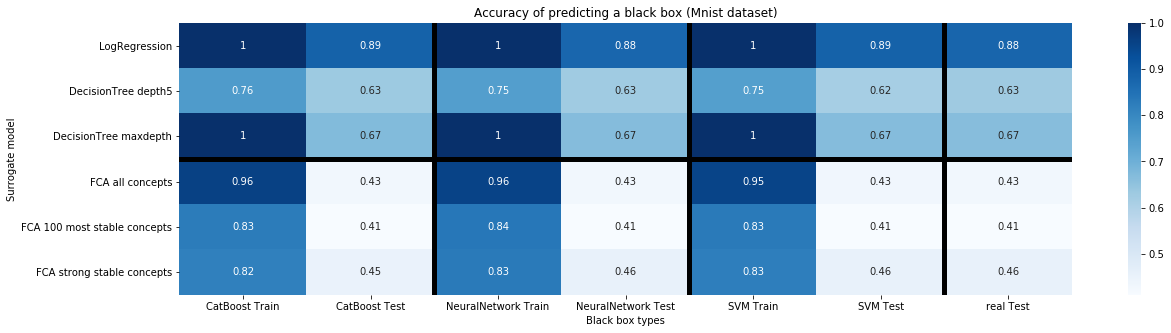

In [111]:
plt.figure(figsize=(20,5))
sns.heatmap(cds, annot=True, cmap='Blues')
plt.yticks(rotation=0)
#plt.xticks(rotation=45)
plt.axhline(3, color='black', linewidth=5)
for x in [2,4,6]:
    plt.axvline(x, color='black', linewidth=5)

plt.title('Accuracy of predicting a black box (Mnist dataset)')
plt.xlabel('Black box types')
plt.ylabel('Surrogate model')
plt.show()

In [112]:
print(cds.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  CatBoost Train &  CatBoost Test &  NeuralNetwork Train &  NeuralNetwork Test &  SVM Train &  SVM Test &  real Test \\
interp\_type                  &                 &                &                      &                     &            &           &            \\
\midrule
LogRegression                &        1.000000 &          0.887 &             1.000000 &               0.876 &   1.000000 &     0.887 &      0.879 \\
DecisionTree depth5          &        0.755333 &          0.634 &             0.747222 &               0.628 &   0.746444 &     0.617 &      0.630 \\
DecisionTree maxdepth        &        1.000000 &          0.671 &             1.000000 &               0.668 &   1.000000 &     0.668 &      0.666 \\
FCA all concepts             &        0.960889 &          0.430 &             0.958444 &               0.431 &   0.954000 &     0.434 &      0.430 \\
FCA 100 most stable concepts &        0.829333 &          0.413 &             0.8

In [ ]:
plt.figure(figsize=(20,5))
sns.heatmap(cds, annot=True, cmap='Blues')
plt.yticks(rotation=0)
#plt.xticks(rotation=45)
plt.axhline(3, color='black', linewidth=5)
for x in [2,4,6]:
    plt.axvline(x, color='black', linewidth=5)

plt.title('Accuracy of predicting a black box (Mnist dataset)')
plt.xlabel('Black box types')
plt.ylabel('Surrogate model')
plt.show()

In [69]:
len(fm.get_concepts())

956

In [339]:
len(fm.calc_cover_of_concepts(fm.get_concepts()))

1000

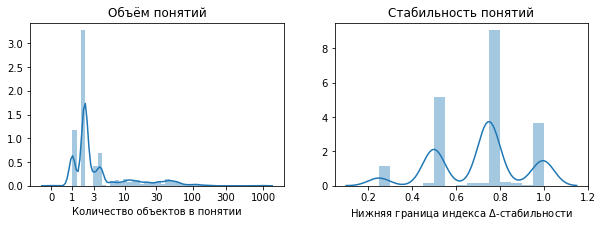

In [336]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
sns.distplot(np.log1p([len(c.get_extent()) for c in fm.get_concepts()]))
xticks = [0, 1, 3, 10, 30, 100, 300, 1000]
plt.xticks(np.log1p(xticks), xticks)
plt.title('Объём понятий')
plt.xlabel('Количество объектов в понятии')

plt.subplot(1,2,2)
sns.distplot([c._metrics['stab_min_bound'] for c in fm.get_concepts() if c._metrics['stab_min_bound'] is not None])
plt.title('Стабильность понятий')
plt.xlabel(r'Нижняя граница индекса $\Delta$-стабильности')
plt.show()

In [62]:
lr = LogisticRegression()
lr.fit(ds, preds_ds.loc[ds.index, 'preds_nn'])
preds_test_real = lr.predict(ds)
accuracy_score(preds_ds.loc[ds.index,'preds_nn'], preds_test_real),# f1_score(preds_ds.loc[ds.index,'preds_nn'], preds_test_real)

/root/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



(1.0,)

In [63]:
dt_small = DecisionTreeClassifier(max_depth=5)
dt_small.fit(ds, preds_ds.loc[ds.index,'preds_nn'])
preds_test_real = dt_small.predict(ds)
accuracy_score(preds_ds.loc[ds.index,'preds_nn'], preds_test_real)

0.746

In [64]:
dt_large = DecisionTreeClassifier()
dt_large.fit(ds, preds_ds.loc[ds.index,'preds_nn'])
preds_test_real = dt_large.predict(ds)
accuracy_score(preds_ds.loc[ds.index,'preds_nn'], preds_test_real)

1.0

In [65]:
g = '321'

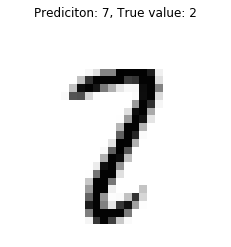

In [340]:
plt.imshow(intent_to_picture(ds.loc[g], ds.columns), cmap='Greys')
plt.title(f"Prediciton: {preds_ds.loc[g, 'preds_nn']}, True value: {preds_ds.loc[g, 'y']}")
plt.axis('off')
plt.show()

In [67]:
lr.predict_proba(ds.loc[[g]])

array([[2.11361946e-04, 8.19673380e-04, 5.40051265e-03, 2.14399958e-02,
        1.95694075e-05, 4.16679920e-04, 2.20827332e-05, 9.55152046e-01,
        6.62398773e-04, 1.58556791e-02]])

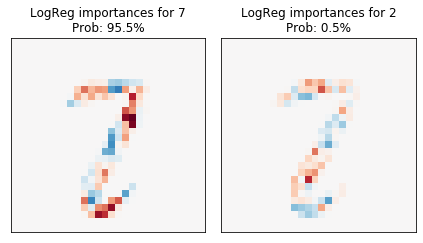

In [68]:
for idx, dig in enumerate([7,2]):
    plt.subplot(1,2,idx+1)
    #plt.imshow(lr.coef_[dig].reshape(img_rows, img_cols), cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    plt.imshow(intent_to_picture(lr.coef_[dig]*ds.loc[g], ds.columns), cmap='RdBu_r', vmin=-0.5, vmax=0.5 )
    plt.title(f'LogReg importances for {dig}\nProb: {lr.predict_proba(ds.loc[[g]])[0][dig]:.1%}')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [71]:
preds_ds[(preds_ds['preds_nn']!=preds_ds['y'])].head()

,preds_cb,preds_svc,preds_nn,y
321,7,7,7,2
340,3,3,3,5
445,0,0,0,6
582,2,2,2,8
720,8,8,8,5


In [72]:
def get_decisions(estimator, X_test, col_names):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
            
    node_indicator = estimator.decision_path(X_test)

    leave_id = estimator.apply(X_test)

    # Now, it's possible to get the tests that were used to predict a sample or
    # a group of samples. First, let's make it for the sample.

    # HERE IS WHAT YOU WANT
    sample_id = 0
    node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                        node_indicator.indptr[sample_id + 1]]

    print('Rules used to predict sample %s: ' % sample_id)
    for node_id in node_index:

        if leave_id[sample_id] == node_id:  # <-- changed != to ==
            #continue # <-- comment out
            print("leaf node {} reached, no decision here".format(leave_id[sample_id])) # <--

        else: # < -- added else to iterate through decision nodes
            if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
                threshold_sign = "<="
            else:
                threshold_sign = ">"

            print("decision id node %s : (%s (= %s) %s %s)"
                  % (node_id,
                     col_names[feature[node_id]],
                     X_test[sample_id, feature[node_id]], # <-- changed i to sample_id
                     threshold_sign,
                     threshold[node_id]))

In [345]:
dt_small.predict_proba(ds.loc[[g]])[0][[2,7]]

array([0.17142857, 0.37142857])

In [73]:
get_decisions(dt_small, ds.loc[[g]].values, ds.columns)

Rules used to predict sample 0: 
decision id node 0 : ((11,14) (= 0.0) <= 0.36666667461395264)
decision id node 1 : ((20,10) (= 0.32941177) > 0.0019607844296842813)
decision id node 17 : ((15,15) (= 0.9882353) > 0.009803922148421407)
decision id node 25 : ((11,10) (= 0.0) <= 0.03137254994362593)
decision id node 26 : ((5,14) (= 0.0) <= 0.003921568859368563)
leaf node 27 reached, no decision here


In [346]:
dt_large.predict_proba(ds.loc[[g]])[0][[2,7]]

array([0., 1.])

In [74]:
get_decisions(dt_large, ds.loc[[g]].values, ds.columns)

Rules used to predict sample 0: 
decision id node 0 : ((11,14) (= 0.0) <= 0.36666667461395264)
decision id node 1 : ((20,10) (= 0.32941177) > 0.0019607844296842813)
decision id node 145 : ((15,15) (= 0.9882353) > 0.009803922148421407)
decision id node 171 : ((11,10) (= 0.0) <= 0.03137254994362593)
decision id node 172 : ((5,14) (= 0.0) <= 0.003921568859368563)
decision id node 173 : ((8,17) (= 0.95686275) > 0.04313725605607033)
decision id node 177 : ((9,12) (= 0.0) <= 0.1196078471839428)
decision id node 178 : ((16,16) (= 0.0) <= 0.11764705926179886)
decision id node 179 : ((12,17) (= 0.92941177) > 0.8568627536296844)
leaf node 181 reached, no decision here


In [75]:
len(fm.get_concepts())

956

In [76]:
fm.construct_lattice()

In [77]:
fm.calc_stability_approx()

/opt/lib/fca_interp.py:750: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:751: RuntimeWarning:

divide by zero encountered in log2



In [79]:
for c in tqdm(fm.get_concepts()):
    ext_ = c.get_extent()
    if len(ext_)==0:
        continue
    c._metrics['mean_y_true'] = preds_ds.loc[ext_, 'y'].value_counts().sort_values(ascending=False).index[0] #.mode()
    for i in range(10):
        c._metrics[f'mean_y_true_{i}'] = (preds_ds.loc[ext_, 'y'].astype(int)==int(i)).mean()
    for bb_type in bb_types:
        c._metrics[f'mean_y_preds_{bb_type}'] = preds_ds.loc[ext_, f"preds_{bb_type}"].value_counts().sort_values(ascending=False).index[0] #.mode()
        for i in range(10):
            c._metrics[f'mean_y_preds_{bb_type}_{i}'] = (preds_ds.loc[ext_, f'preds_{bb_type}']==i).mean()


In [80]:
stable_concepts = sorted(fm.get_concepts(), key=lambda c: -fcai.get_not_none(c._metrics['stab_min_bound'],-1000))[:100]
strong_stable_concepts = [c for c in stable_concepts if abs(c._metrics['mean_y_preds_nn_7']-0.5)+0.5>=0.6]
#stable_concepts[0]
len(strong_stable_concepts)

100

In [81]:
max_concepts = sorted([c for c in strong_stable_concepts if g in c.get_extent() and len(c.get_extent())>1], key=lambda c: len(c.get_extent()))
print(len(max_concepts))
for i in range(len(max_concepts)):
    if i>=len(max_concepts):
        break
    c = max_concepts[i]
    max_concepts = [c_ for c_ in max_concepts if c_==c or not c.is_subconcept_of(c_)]
len(max_concepts)

6


3

In [82]:
max_concepts = sorted(max_concepts, key=lambda c: len(c.get_extent()))

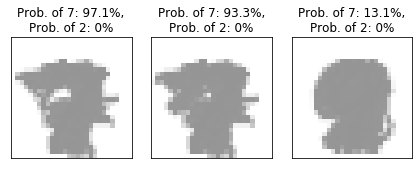

In [83]:
for idx, c in enumerate(max_concepts):
    plt.subplot(1,3,idx+1)
    plt.imshow(intent_to_picture(c.get_intent(), ds.columns), cmap='Greys', vmax=1, vmin=0)
    plt.title(f"Prob. of 7: {c._metrics['mean_y_preds_nn_7']:.1%},\nProb. of 2: {c._metrics['mean_y_preds_nn_2']:.0%}")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [84]:
ds.shape

(1000, 784)

In [85]:
import shap

In [89]:
x_test_nn.shape

(10000, 28, 28, 1)

In [133]:
# select a set of background examples to take an expectation over
background = x_test_nn[:100]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test_nn[int(g):int(g)+1])

# plot the feature attributions
#shap.image_plot(shap_values, -x_test[1:5])

In [233]:
shap_values_ = shap_values

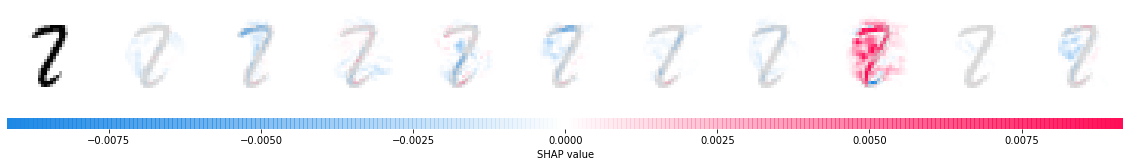

In [235]:
shap.image_plot(shap_values_, -x_test_nn[int(g):int(g)+1])

In [237]:
import lime

In [240]:
import lime

In [242]:
from lime import lime_image

In [273]:
from skimage.color import gray2rgb,  rgb2gray, label2rgb

In [243]:
explainer = lime_image.LimeImageExplainer()

In [253]:
X_vec = np.stack([gray2rgb(iimg) for iimg in x_test_nn.reshape((-1, 28, 28))],0)

In [254]:
X_vec.shape

(10000, 28, 28, 3)

In [292]:
def f_(X):
    return model.predict_proba(rgb2gray(X).reshape(-1,28,28,1))

In [280]:
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [281]:
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [316]:
    explanation = explainer.explain_instance(X_vec[int(g)], f_, top_labels=10, hide_color=False, num_samples=100000, )#segmentation_fn=segmenter)

In [300]:
from skimage.segmentation import mark_boundaries

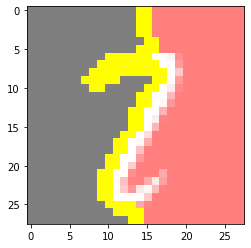

In [317]:
temp, mask = explanation.get_image_and_mask(2, positive_only=False, num_features=5, hide_rest=False, min_weight = 0.01)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

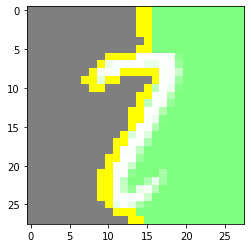

In [318]:
temp, mask = explanation.get_image_and_mask(7, positive_only=False, num_features=5, hide_rest=False, min_weight = 0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20MNIST%20and%20RF.ipynb

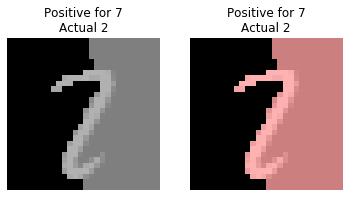

In [334]:
plt.subplot(1,2,1)
emp, mask = explanation.get_image_and_mask(2, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
plt.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
plt.title('Positive for {}\nActual {}'.format(7, 2))
plt.axis('off')


plt.subplot(1,2,2)
emp, mask = explanation.get_image_and_mask(7, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
plt.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
plt.title('Positive for {}\nActual {}'.format(7, 2))
plt.axis('off')
plt.show()